# Lab 4: CCD

## Part 1: Gain and Read Noise

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from astropy.io import fits
import numpy as np
import glob
from scipy.optimize import curve_fit

In [2]:
#supressing exp overflow error
np.seterr(over=None)

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
#setting path to data location
datapath = '/mnt/c/Users/loabn/Downloads/FlatsData/'

In [46]:
#reading in bias files
bias=[]

biasfiles = glob.glob(datapath+'Bias*.fit')

for file in biasfiles:
    bias.append(fits.getdata(file, ext=0).astype(np.int))


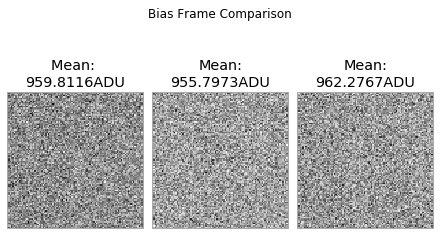

In [47]:
#Bias frame comparison

fig, axes = plt.subplots(1,3, constrained_layout=True)
axes[0].imshow(bias[4][100:200, 100:200], cmap='Greys')
axes[0].grid(False)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title('Mean: \n'+ str(np.asarray(bias[4][100:200, 100:200]).mean()) +'ADU')

axes[1].imshow(bias[4][1045:1145, 1045:1145], cmap='Greys')
axes[1].grid(False)
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title('Mean:\n'+ str(np.asarray(bias[4][1045:1145, 1045:1145]).mean()) +'ADU')

axes[2].imshow(bias[4][750:850, 100:200], cmap='Greys')
axes[2].grid(False)
axes[2].set_xticks([])
axes[2].set_yticks([])
axes[2].set_title('Mean:\n'+ str(np.asarray(bias[4][750:850, 100:200]).mean()) +'ADU')


fig.suptitle('Bias Frame Comparison')

In [5]:
#reading in flats at each light level
lightlevels = [100, 119, 140]
flats = []
for light in lightlevels:
    levelflats = []
    flatfiles = glob.glob(datapath+'Flat{}*.fit'.format(light))
    for file in flatfiles:
            levelflats.append(fits.getdata(file, ext=0).astype(np.int))
    flats.append(levelflats)

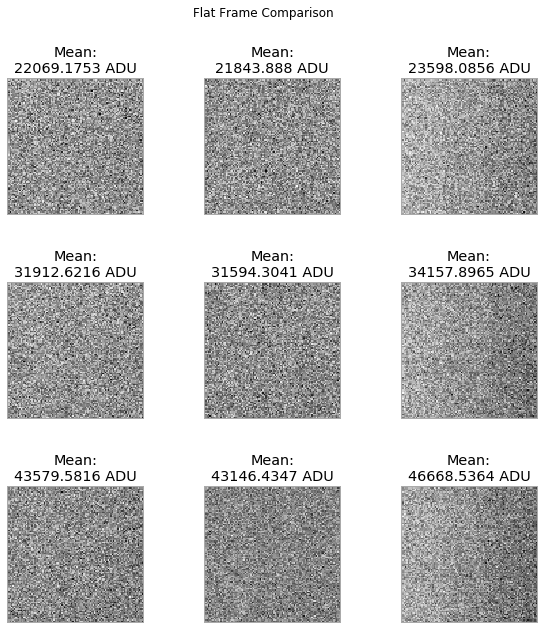

In [56]:
#Comparing Flats Segments
fig, axes = plt.subplots(3,3, figsize=(10,10))

for i in range(0,3):
    lightlevel = i
    for j in range(0,3):
        if j == 0:
            snap = flats[lightlevel][0][750:850, 100:200]
            mymean = np.asarray(snap).mean()
        elif j==1:
            snap = flats[lightlevel][0][100:200, 100:200]
            mymean = np.asarray(snap).mean()
        elif j==2:
            snap = flats[lightlevel][0][1045:1145, 1045:1145]
            mymean = np.asarray(snap).mean()
        
        axes[i,j].imshow(snap, cmap='Greys')
        axes[i,j].grid(False)
        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])
        axes[i,j].set_title('Mean:\n'+ str(mymean) +' ADU')


fig.suptitle('Flat Frame Comparison')

In [6]:
#READNOISE IN ADU
#finding readnoise by taking standard deviation of bias frames
standev = np.asarray(bias).std(axis=0)
readnoise = standev.mean()
print("The read noise is", readnoise, 'ADU.')

The read noise is 19.478302646200714 ADU.


In [7]:
#GAIN
#averaging all the bias frames to reduce the error in the mean
B_avg = np.asarray(bias).mean(axis=0)
means = []
varis = []


#going through each flat, correcting it using the bias frame, and taking its mean and variance.
for lightlevel in flats:
    difference = lightlevel-B_avg
    variance = difference.var(axis=0)
    varmean = variance.mean()
    
    mean = difference.mean()
    
    means.append(mean)
    varis.append(varmean)

In [8]:
#defining linear function and performing curvefit
def linear(x,m,b):
    return m*x+b

m0 = (means[-1]-means[0])/(varis[-1]-varis[0])
b0=0
guess=(m0,b0)

coeffs, fiterr = curve_fit(linear, varis, means, p0=guess)

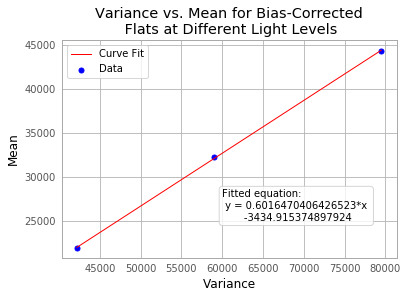

In [9]:
#plotting result
plt.scatter(varis, means, s=100, c='blue', marker='.', label="Data")
plt.plot(varis, linear(np.array(varis), *coeffs), color='r', linewidth = 1, label = "Curve Fit")
plt.title('')
plt.xlabel('Variance')
plt.ylabel('Mean')
plt.title('Variance vs. Mean for Bias-Corrected\n Flats at Different Light Levels')
plt.legend()
plt.text(60000, 25000, 'Fitted equation: \n y = {}*x \n       {}'.format(*coeffs), bbox=dict(boxstyle = 'round', facecolor='white',alpha=0.8))

In [10]:
gain = coeffs[0]
print('The gain is {} electrons/ADU, so the Read Noise in electrons is {}.'.format(gain, gain*readnoise))

The gain is 0.6016470406426523 electrons/ADU, so the Read Noise in electrons is 11.719063143828603.


In [11]:
#FULL-WELL ESTIMATION
saturation_adu = 65536
fullwell_e = saturation_adu*gain
print('The Full Well Depth is {} electrons.'.format(fullwell_e))

The Full Well Depth is 39429.54045555686 electrons.


## Part 2: Dark Current and Silicon Bandgap

In [12]:
#Defining a rounding function to put data from sufficiently close temperatures together
def roundhalfint(n):
    if int(n)!=n:
        decimal = float(str(n).split('.')[-1][0])
        if float(decimal)>=3 and float(decimal)<7:
            val = float(str(n).split('.')[0]+'.5')
        elif float(decimal)<3:
            val = float(str(n).split('.')[0])
        elif float(decimal)>=7:
            val = float(str(n).split('.')[0])+1
    else:
        val = n
    return val

In [13]:
#reading in the darks, and storing their temperatur and exposure length
datapath = '/mnt/c/Users/loabn/Downloads/DarkData/'

darks=[]

temps = []
times = []

darksbias = []

darkfiles = glob.glob(datapath+'*Dark*.fit')
darkbiasfiles = glob.glob(datapath+'Bias2*.fit')


for file in darkfiles:
    vals = file.split('T')[1]
    
    temp = roundhalfint(float(vals.split('E')[0]) + 273)
    time = float(vals.split('p')[1].split('.')[0].split('-')[0])
    
    darks.append(fits.getdata(file, ext=0).astype(np.int))
    
    temps.append(temp)
    times.append(time)
    
for file in darkbiasfiles:
    darksbias.append(fits.getdata(file, ext=0).astype(np.int))
    

In [14]:
#averaging over bias frames to correct darks
BD_avg = np.asarray(darksbias).mean(axis=0)

In [15]:
#defining the expression for Dark Current
def DarkCurrent(T, A, E_g):
    k = 1.38e-16 * 1/(1.602e-12)
    return (A*(T**(3/2)))*(np.exp((-(E_g)/(2*k*T))))

In [17]:
#Finding the Dark current 

darkcurrents = []

for i in range(len(darks)):
    difference = (np.asarray(darks[i]) - BD_avg)/times[i]
    DC = difference.mean()
    darkcurrents.append(DC)

In [18]:
#condensing data from same temperature points
reducedtemps = list(set(temps))
reduceddc = []
for temp in reducedtemps:
    matches = np.where(np.asarray(temps)==temp)
    currents = np.asarray(darkcurrents)[matches[0]]
    reduceddc.append(currents.mean())

In [19]:
#sorting the points so the temperatures are in order
points = []
for i in range(len(reducedtemps)):
    points.append((reducedtemps[i], reduceddc[i]))

#sorting by the first element of a temperature, dark_current tuple
points.sort(key= lambda x: x[0])

templist = []
dclist = []
for point in points:
    templist.append(point[0])
    dclist.append(point[1])

In [21]:
#fitting the Dark Current formula to the data
A0 = (1)
E0= (1)
guess=np.array([A0,E0])

coeffs, fiterr = curve_fit(DarkCurrent, np.asarray(templist), np.asarray(dclist), p0=guess)

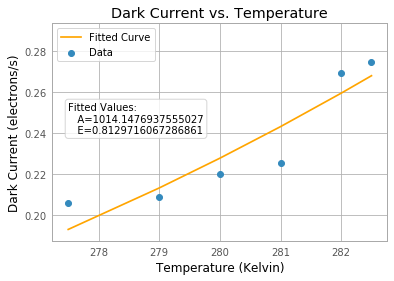

In [22]:
#plotting the data and fitted curve
plt.scatter(templist, dclist, label='Data')
plt.plot(templist, DarkCurrent(np.asarray(templist), *coeffs), c='orange', label='Fitted Curve')
plt.xlabel('Temperature (Kelvin)')
plt.ylabel('Dark Current (electrons/s)')
plt.title('Dark Current vs. Temperature')
plt.legend(loc='upper left')

plt.text(277.5, 0.24, 'Fitted Values:\n   A={}\n   E={}'.format(*coeffs), bbox=dict(boxstyle = 'round', facecolor='white',alpha=0.8))

In [23]:
print('The A constant found was {}. The Bandgap E found was {}.'.format(*coeffs))

The A constant found was 1014.1476937555027. The Bandgap E found was 0.8129716067286861.
